# Predicting severity of collisions


This notebook analyzes a data set containing collisions in the city of Seattle. This report presents a visualization of the data and a model to predict the severity of the accidents depending on certain attributes.

DATASET:

Title: Collisions (2004 to present)
Abstract: All collisions provided by SPD and recorded by Traffic Records.
Contact email: DOT_IT_GIS@seattle.gov


Loading the necessary libraries

In [81]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sn
%matplotlib inline

Reading the dataset

In [82]:
Collisions = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv', low_memory = False)

Having a first look of the dataset

In [158]:
Collisions.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## Data understanding

An initial analysis of the data to see the formatting of the data contained in the data set and the shape of the data set

In [84]:
Collisions.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

In [85]:
Collisions.shape

(194673, 38)

## Initial data cleaning

The data set contains many attributes which are not useful either for visualization nor prediction of collisions severity. Therefore I will remove some of this attributes before starting cleaning the data set. It also makes it easier to visualize the data.

In [159]:
Collisions_red = Collisions.drop(['OBJECTID', 'INCKEY', 'COLDETKEY', 'LOCATION','EXCEPTRSNCODE','EXCEPTRSNDESC', 'SEVERITYCODE.1','SEVERITYDESC','COLLISIONTYPE','PEDCYLCOUNT','REPORTNO','INCDATE','INCDTTM','INATTENTIONIND','PEDROWNOTGRNT','SDOT_COLCODE','SDOT_COLDESC','STATUS','SDOTCOLNUM','ST_COLCODE','ST_COLDESC','SEGLANEKEY','SPEEDING','INTKEY'], axis=1)
Collisions_red.head()

,SEVERITYCODE,X,Y,ADDRTYPE,PERSONCOUNT,PEDCOUNT,VEHCOUNT,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,Intersection,2,0,2,At Intersection (intersection related),N,Overcast,Wet,Daylight,0,N
1,1,-122.347294,47.647172,Block,2,0,2,Mid-Block (not related to intersection),0,Raining,Wet,Dark - Street Lights On,0,N
2,1,-122.334540,47.607871,Block,4,0,3,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight,0,N
3,1,-122.334803,47.604803,Block,3,0,3,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,0,N
4,2,-122.306426,47.545739,Intersection,2,0,2,At Intersection (intersection related),0,Raining,Wet,Daylight,0,N


I am going to remove all the rows having missing/NaN data

In [160]:
Collisions_red.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
Collisions_red

,SEVERITYCODE,X,Y,ADDRTYPE,PERSONCOUNT,PEDCOUNT,VEHCOUNT,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,Intersection,2,0,2,At Intersection (intersection related),N,Overcast,Wet,Daylight,0,N
1,1,-122.347294,47.647172,Block,2,0,2,Mid-Block (not related to intersection),0,Raining,Wet,Dark - Street Lights On,0,N
2,1,-122.334540,47.607871,Block,4,0,3,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight,0,N
3,1,-122.334803,47.604803,Block,3,0,3,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,0,N
4,2,-122.306426,47.545739,Intersection,2,0,2,At Intersection (intersection related),0,Raining,Wet,Daylight,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,-122.290826,47.565408,Block,3,0,2,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,0,N
194669,1,-122.344526,47.690924,Block,2,0,2,Mid-Block (not related to intersection),N,Raining,Wet,Daylight,0,N
194670,2,-122.306689,47.683047,Intersection,3,0,2,At Intersection (intersection related),N,Clear,Dry,Daylight,0,N
194671,2,-122.355317,47.678734,Intersection,2,0,1,At Intersection (intersection related),N,Clear,Dry,Dusk,0,N


#### Transforming data to numerical values

Since many of the attributes are not numerical, a tranformation is needed to convert them to numerical. This transformation is usefull to evaluate correlation and also develop the prediction model

In [105]:
#Evaluation of the types to know which attributes have to be transformed
Collisions_red.dtypes

SEVERITYCODE      int64
X               float64
Y               float64
ADDRTYPE         object
PERSONCOUNT       int64
PEDCOUNT          int64
VEHCOUNT          int64
JUNCTIONTYPE     object
UNDERINFL        object
WEATHER          object
ROADCOND         object
LIGHTCOND        object
CROSSWALKKEY      int64
HITPARKEDCAR     object
dtype: object

The attributes that are going to be transformed are ADDRTYPE, JUNCTIONTYPE, UNDERINFL, WEATHER, ROADCOND, LIGHTCOND. The type of these attributes is "object"

In [161]:
#A dictionary is defined to assign a number to each object in the attribute
weather = {'Overcast': 0, 'Raining': 1, 'Clear': 3,'Unknown': 4,'Snowing': 5,'Fog/Smog/Smoke': 6, 'Sleet/Hail/Freezing Rain': 7, 'Blowing Sand/Dirt': 8,
       'Severe Crosswind': 9, 'Partly Cloudy': 10, 'Other': 11}
#Assign these different key-value pair from above dictiionary to your table
Collisions_red.WEATHER = [weather[item] for item in Collisions_red.WEATHER]

In [162]:
condition = {'Wet': 0, 'Dry': 1, 'Unknown': 3,'Snow/Slush': 4,'Ice': 5,'Other': 6, 'Sand/Mud/Dirt': 7, 'Standing Water': 8,
       'Oil': 9}
Collisions_red.ROADCOND = [condition[item] for item in Collisions_red.ROADCOND]

In [163]:
light = {'Daylight': 0, 'Dark - Street Lights On': 1, 'Dark - No Street Lights': 2,
       'Unknown': 3, 'Dusk': 4, 'Dawn': 5, 'Dark - Street Lights Off': 6, 'Other': 7,
       'Dark - Unknown Lighting': 8}
Collisions_red.LIGHTCOND = [light[item] for item in Collisions_red.LIGHTCOND]

In [164]:
parked = {'Y': 0, 'N': 1}
Collisions_red.HITPARKEDCAR = [parked[item] for item in Collisions_red.HITPARKEDCAR]

In [165]:
junction = {'At Intersection (intersection related)': 0,
       'Mid-Block (not related to intersection)': 1, 'Driveway Junction': 2,
       'At Intersection (but not related to intersection)': 3,
       'Mid-Block (but intersection related)': 4, 'Ramp Junction': 5, 'Unknown': 6}
Collisions_red.JUNCTIONTYPE = [junction[item] for item in Collisions_red.JUNCTIONTYPE]

In [166]:
Addrtype = {'Intersection': 0, 'Block': 1}
Collisions_red.ADDRTYPE = [Addrtype[item] for item in Collisions_red.ADDRTYPE]

In [167]:
underinfl = {'N': 0, 'Y': 1,'0':0,'1':1}
Collisions_red.UNDERINFL = [underinfl[item] for item in Collisions_red.UNDERINFL]

Let's have a look at the transformed data set

In [168]:
Collisions_red.head()

,SEVERITYCODE,X,Y,ADDRTYPE,PERSONCOUNT,PEDCOUNT,VEHCOUNT,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,0,2,0,2,0,0,0,0,0,0,1
1,1,-122.347294,47.647172,1,2,0,2,1,0,1,0,1,0,1
2,1,-122.334540,47.607871,1,4,0,3,1,0,0,1,0,0,1
3,1,-122.334803,47.604803,1,3,0,3,1,0,3,1,0,0,1
4,2,-122.306426,47.545739,0,2,0,2,0,0,1,0,0,0,1


#### Correlation matrix

A correlation matrix helps to identify redundant information e.g. if features are highly correlated are highly correlated, therefore we need just one of these features. This information will help to select the most meaningful attributes to try to predict the severity of a collision

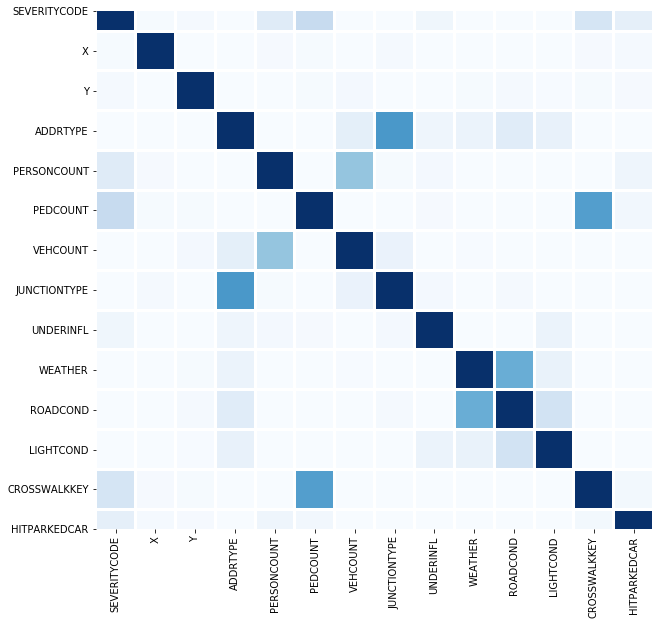

In [134]:
Corr = Collisions_red.corr(method='pearson', min_periods=1)
fig, ax = plt.subplots(figsize=(10,10))
ax = sn.heatmap(Corr, cbar=0, linewidths=2,vmax=1, vmin=0, square=True, cmap='Blues')
plt.show()

There are some attributes that are highly correlated but not to the point to excluded them. I will leave the set of attriutes as it is for the next steps.

## Initial data analysis

The first step before start targeting attributes and cleaning the data is a short analysis. Most of the document collisions occur in a Block address type

In [137]:
#Count the type of collision by address type
ADDRTYPE_Count = Collisions['ADDRTYPE'].value_counts()
print(ADDRTYPE_Count)

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64


In [138]:
SEVERITY_Count = Collisions['SEVERITYCODE'].value_counts()
print(SEVERITY_Count)

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64


### Collisions over time

TO display the number of collisions over time

In [151]:
INCDATE = Collisions.groupby(['INCDATE'])['SEVERITYCODE'].count().reset_index()

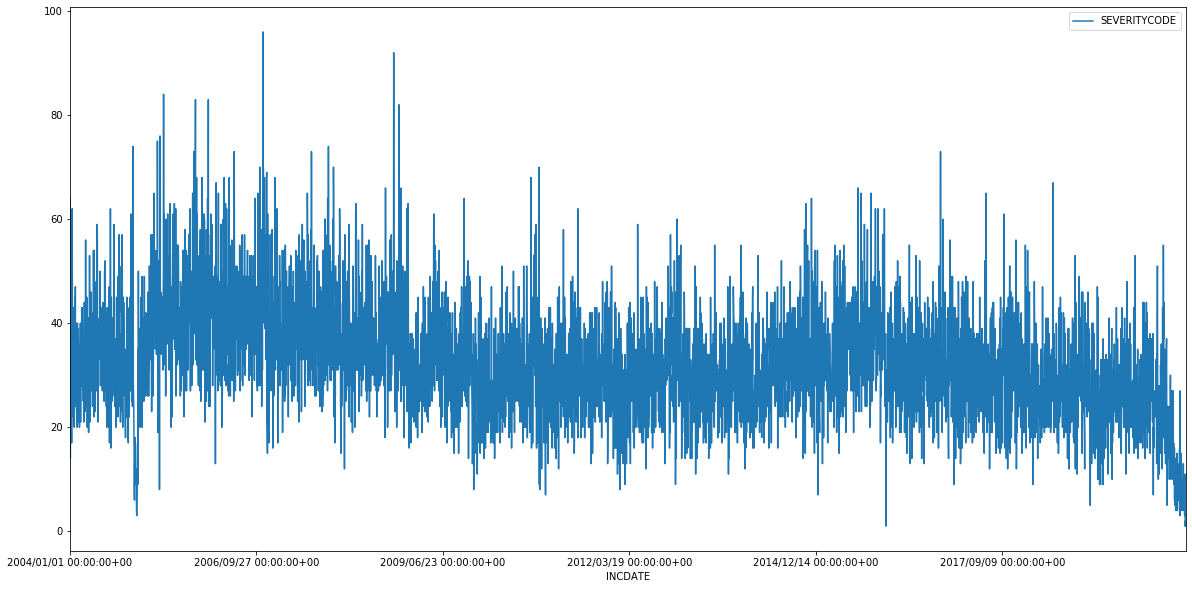

In [152]:
INCDATE.plot(x='INCDATE', y='SEVERITYCODE', figsize=(20, 10))

## Modelling

From the data description I choose the features that may be used for a classification. In this study I will mainly focus on numerical features or features that can be converted to a numerical. The other I will dismiss for the purpose of the classification.

I have focused on three specific attributes that describe the conditions when a collision occured: WEATHER, ROADCOND, LIGHTCOND

I am going to use the K-Nearest Neighbor approach. This is a supervised method that is suitable to our problem, since it is a classification problem

For the model I will use the scikit-learn library. The approach will be the KNN (K- Nearest Neighbor)
To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array:

In [171]:
#Define the attributes that will be used as variables in the prediction model
X = Collisions_red[['ADDRTYPE','PERSONCOUNT','PEDCOUNT','VEHCOUNT','JUNCTIONTYPE','UNDERINFL','CROSSWALKKEY','HITPARKEDCAR','WEATHER', 'ROADCOND','LIGHTCOND']] .values  #.astype(float)
X[0:5]

array([[0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0],
       [1, 2, 0, 2, 1, 0, 0, 1, 1, 0, 1],
       [1, 4, 0, 3, 1, 0, 0, 1, 0, 1, 0],
       [1, 3, 0, 3, 1, 0, 0, 1, 3, 1, 0],
       [0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0]])

SEVERITYCODE is define as the target label

In [172]:
y = Collisions_red['SEVERITYCODE'].values
y[0:5]

array([2, 1, 1, 1, 2])

## Normalize Data 

Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases. The normalization is important to avoind giving some attributes more weight than to other

In [173]:
#Normalizing the date using StandardScaler
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-1.36332097, -0.35017557, -0.1931701 ,  0.04569263, -0.89555279,
        -0.2269065 , -0.13929709,  0.1804816 , -1.65105465, -1.08791562,
        -0.56836046],
       [ 0.73350299, -0.35017557, -0.1931701 ,  0.04569263, -0.09050657,
        -0.2269065 , -0.13929709,  0.1804816 , -0.93966471, -1.08791562,
         0.26107311],
       [ 0.73350299,  1.11080389, -0.1931701 ,  1.83102649, -0.09050657,
        -0.2269065 , -0.13929709,  0.1804816 , -1.65105465,  0.0863452 ,
        -0.56836046],
       [ 0.73350299,  0.38031416, -0.1931701 ,  1.83102649, -0.09050657,
        -0.2269065 , -0.13929709,  0.1804816 ,  0.48311517,  0.0863452 ,
        -0.56836046],
       [-1.36332097, -0.35017557, -0.1931701 ,  0.04569263, -0.89555279,
        -0.2269065 , -0.13929709,  0.1804816 , -0.93966471, -1.08791562,
        -0.56836046]])

### Train Test Split  

I defined the train-test split to be 80% for traning and 20% for testing

In [175]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (144068, 11) (144068,)
Test set: (36018, 11) (36018,)


### Training the model

As mentioned above KNN will be used to train the model. 

In [176]:
from sklearn.neighbors import KNeighborsClassifier

k = 4 was found to be the optimum

In [187]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [188]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([1, 1, 1, 1, 2])

### Evaluating the model

Now that the model has been trained it is time to evaluate it with the predefined test set

In [189]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7351528444901019
Test set Accuracy:  0.7264978621800211


The accuracy of the model is more than 70%. The model does not overfit the training data since the accuracy of the training set and test set is very close.

This model "model" can be used to predict the severity of a collision in the city of Seattle.

### Visualization of data in a map

Having a model helps to predict the severity of a collision. It would be useful to visualize where this collisions where located. For this purpose I will use "folium".

In [190]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

# All requested packages already installed.



Define latitude and longitude of the city of Seattle

In [191]:
Lat = 47.6
Lon = -122.32

Check the if the map is correctly centered in Seattle and the zoom is correct

In [193]:
Seattle = folium.Map(location=[Lat, Lon], zoom_start=11)
Seattle

500 Collisions are selected as representative to show the collisions in the map

In [194]:
# get the first 500 collisions
limit = 500
Collisions_red_500 = Collisions_red.iloc[0:limit, :]

In [195]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(Collisions_red_500.Y, Collisions_red_500.X):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
Seattle.add_child(incidents)